In [155]:
import warnings
warnings.filterwarnings("ignore")
from run import main
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib.lines import Line2D

In [156]:
# set up dataframe for collecting event data
"""
    start_time: the start time of the simulation (can only be used when you have saved state at that given timestamp)
    finish_time: the total simulation time
    mtd_type: 'shuffle_diversity', 'shuffle', diversity
    checkpoints: a list of simulation timestamp for state saving e.g. [1000, 5000, 7000]
"""
SIM_TIME = 5000
mtd_type = 'shuffle_diversity'
time_network, adversary = main(finish_time=SIM_TIME, mtd_type=mtd_type)

Adversary: Start SCAN_HOST at 0.0s.
MTD: HostTopologyShuffle triggered 0.0s
MTD: HostTopologyShuffle deployed in the network at 0.0s.
Adversary: Processed SCAN_HOST at 10.0s.
Adversary: Start ENUM_HOST at 10.0s.
Adversary: Processed ENUM_HOST at 25.0s.
Adversary: Start SCAN_PORT at 25.0s.
MTD: osdiversity triggered 31.6s
MTD: osdiversity deployed in the network at 31.6s.
Adversary: Processed SCAN_PORT at 45.0s.
Adversary: Start EXPLOIT_VULN at 45.0s.
MTD: HostTopologyShuffle finished in 60.6s at 60.6s.
MTD: Interrupted EXPLOIT_VULN at 60.6s!
MTD: osdiversity finished in 30.1s at 61.6s.
MTD: osdiversity triggered 62.5s
MTD: osdiversity deployed in the network at 62.5s.
Adversary: Restarting with SCAN_HOST at 62.6s!
Adversary: Start SCAN_HOST at 62.6s.
Adversary: Processed SCAN_HOST at 72.6s.
Adversary: Start ENUM_HOST at 72.6s.
Adversary: Processed ENUM_HOST at 87.6s.
Adversary: Start SCAN_PORT at 87.6s.
MTD: osdiversity finished in 30.2s at 92.6s.
MTD: Interrupted SCAN_PORT at 92.6s!
M

In [157]:
mtd_operation_record = pd.DataFrame(time_network.get_mtd_stats().get_record())
attack_operation_record = pd.DataFrame(adversary.get_attack_stats().get_record())
current_directory = os.getcwd()
if not os.path.exists(current_directory+'\\data_analysis'):
    os.makedirs(current_directory+'\\data_analysis')

attack_operation_record.to_csv('data_analysis/attack_operation_record_'+str(SIM_TIME)+'_'+mtd_type+'.csv',index=False)
mtd_operation_record.to_csv('data_analysis/mtd_operation_record_'+str(SIM_TIME)+'_'+mtd_type+'.csv', index=False)

In [158]:
# print(time_network.get_mtd_stats().dict())
mtd_operation_record.head()

,name,start_time,finish_time,duration,executed_at
0,HostTopologyShuffle,0.000000,60.553918,60.553918,network
1,osdiversity,31.553768,61.633155,30.079387,application
2,osdiversity,62.461963,92.621012,30.159049,application
3,PortShuffle,93.064513,128.555236,35.490723,application
4,HostTopologyShuffle,123.097565,183.352396,60.254831,network


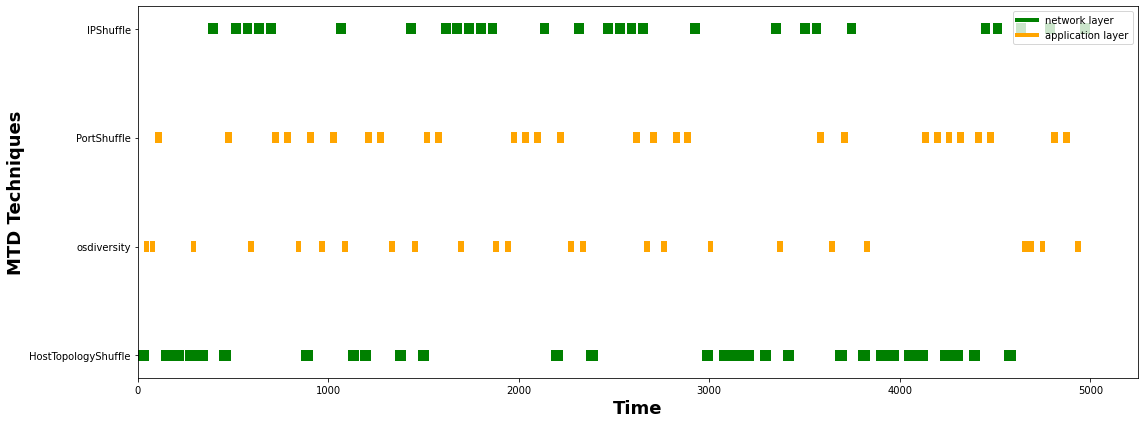

In [159]:
mtd_operation_record['color'] = np.where(mtd_operation_record['executed_at']=='network', 'green', 'orange')
fig, ax = plt.subplots(1, figsize=(16, 6))
ax.barh(mtd_operation_record['name'], mtd_operation_record['duration'], left=mtd_operation_record['start_time'], height=0.1, color=mtd_operation_record['color'])


custom_lines_mtd = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4)]
ax.legend(custom_lines_mtd, ['network layer', 'application layer'], loc='upper right')
plt.xlabel('Time',  weight='bold', fontsize=18)
plt.ylabel('MTD Techniques', weight='bold', fontsize=18)
fig.tight_layout()
plt.savefig('data_analysis/mtd_record.png')
plt.show()

In [160]:
attack_operation_record.head()

,name,start_time,finish_time,duration,current_host,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_host,compromise_users,interrupted_in,interrupted_by
0,SCAN_HOST,0.000000,10.000000,10.000000,-1,0,0,0,None,[],None,None
1,ENUM_HOST,10.000000,25.000000,15.000000,-1,0,0,0,None,[],None,None
2,SCAN_PORT,25.000000,45.000000,20.000000,0,1,0,0,None,[],None,None
3,EXPLOIT_VULN,45.000000,60.553918,15.553918,0,1,0,0,None,[],network,HostTopologyShuffle
4,SCAN_HOST,62.553918,72.553918,10.000000,-1,0,0,0,None,[],None,None


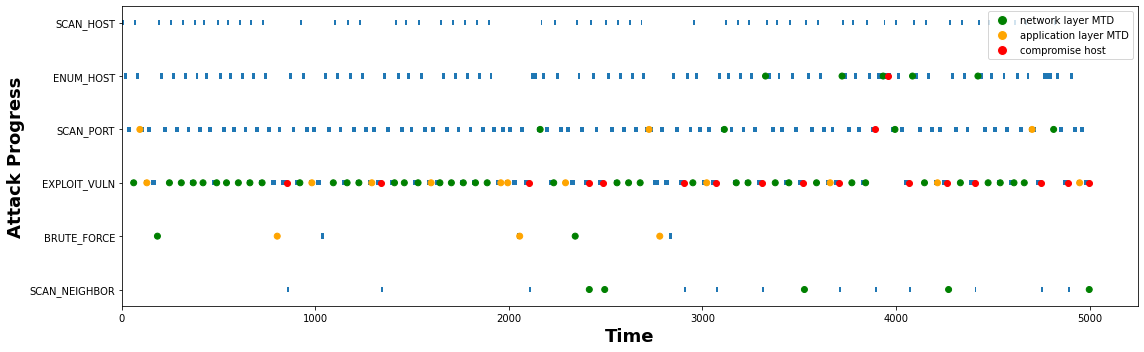

In [161]:
fig2, ax2 = plt.subplots(1, figsize=(16, 5))
ax2.barh(attack_operation_record['name'], attack_operation_record['duration'], left=attack_operation_record['start_time'], height=0.1, zorder=1)


interrupted_record = attack_operation_record[attack_operation_record['interrupted_in']!='None']
interrupted_record['color'] = np.where(interrupted_record['interrupted_in']=='network', 'green', 'orange')
ax2.scatter(interrupted_record['finish_time'], interrupted_record['name'], color=interrupted_record['color'], zorder=2)


compromise_record = attack_operation_record[attack_operation_record['compromise_host'] != 'None']
ax2.scatter(compromise_record['finish_time'], compromise_record['name'], color='red', zorder=2)


custom_lines_attack = [Line2D([0], [0], marker='o',color='w', markerfacecolor='green', markersize=10),
                Line2D([0], [0], marker='o',color='w', markerfacecolor='orange', markersize=10),
                Line2D([0], [0], marker='o',color='w', markerfacecolor='red', markersize=10),]

ax2.legend(custom_lines_attack, ['network layer MTD', 'application layer MTD', 'compromise host'], loc='upper right')

plt.gca().invert_yaxis()
plt.xlabel('Time',  weight='bold', fontsize=18)
plt.ylabel('Attack Progress', weight='bold', fontsize=18)
fig2.tight_layout()
plt.savefig('data_analysis/attack_record.png')
plt.show()

In [162]:
attack_operation_record[(attack_operation_record['name'] == 'SCAN_PORT') & (attack_operation_record['compromise_host'] != 'None')]

,name,start_time,finish_time,duration,current_host,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_host,compromise_users,interrupted_in,interrupted_by
239,SCAN_PORT,3869.970528,3889.970528,20.0,44,3,257,10,44,"[Carissa, Yolanda, Faunie]",None,None


In [163]:
attack_operation_record[(attack_operation_record['name'] == 'EXPLOIT_VULN') & (attack_operation_record['compromise_host'] != 'None')]

,name,start_time,finish_time,duration,current_host,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_host,compromise_users,interrupted_in,interrupted_by
54,EXPLOIT_VULN,824.432856,851.285286,26.852430,1,2,42,0,1,"[Molli, Phyllis, Lulu, Nadine, Antoinette]",None,None
82,EXPLOIT_VULN,1313.279261,1339.160966,25.881705,32,5,86,1,32,"[Chandra, Fredra, Celestina, Darcie, Hetti]",None,None
127,EXPLOIT_VULN,2077.390065,2103.314215,25.924150,32,8,104,2,32,"[Bettine, Caritta, Shellie, Agnes, Aundrea]",None,None
146,EXPLOIT_VULN,2389.213098,2414.622257,25.409158,44,1,114,3,44,"[Sukey, Biddy, Ondrea, Cherilynn]",None,None
151,EXPLOIT_VULN,2462.078804,2487.873467,25.794662,44,2,121,4,44,"[Isadora, Cordi, Jeannine, Fayre]",None,None
176,EXPLOIT_VULN,2877.853069,2903.063167,25.210097,46,2,134,5,46,"[Sophey, Haleigh, Harlie, Jania, Colette]",None,None
186,EXPLOIT_VULN,3043.674490,3068.872120,25.197630,43,2,181,6,43,"[Zenia, Tonie, Codie, Liane, Kylila]",None,None
201,EXPLOIT_VULN,3282.324122,3308.533937,26.209816,42,2,195,7,42,"[Petra, Marjy, Mae, Odelia, Trixi]",None,None
215,EXPLOIT_VULN,3493.290104,3518.397868,25.107764,31,6,197,8,31,"[Viola, Linell, Karlie, Engracia]",None,None
226,EXPLOIT_VULN,3681.642966,3707.059377,25.416410,30,6,223,9,30,"[Carlin, Kacie, Emmie, Rora]",None,None


In [164]:
attack_operation_record[(attack_operation_record['name'] == 'BRUTE_FORCE') & (attack_operation_record['compromise_host'] != 'None')]

,name,start_time,finish_time,duration,current_host,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_host,compromise_users,interrupted_in,interrupted_by
